In [1]:
%matplotlib inline

In [2]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt

In [3]:
sym.init_printing(use_unicode=False, wrap_line=True)

---

# First order approximation

first order approximation of persistence assumes "**current frame only recieves persistence from the previous frame and suppression is ignored**".

then we assume that the persistence ratio is $a$

## without photon noise

stokes vector before modulation is 

$$
S_{0} = 
\begin{bmatrix}
    1 \\
    P_Q \\
    P_U \\
    P_V \\
\end{bmatrix}
$$

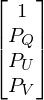

In [4]:
PQ, PU, PV = sym.symbols('P_Q, P_U, P_V')
S0 = sym.Matrix([[1],[PQ],[PU],[PV]])
S0

Observation setup : 

1. the rotating waveplate has angular velocity $\omega = \frac{2\pi}{10} \; rad/s $
2. each frame has exposure $t_{exp} = \frac{5}{35}=\frac{1}{7} \; s$
3. observation has cadence $T = 20 \; s$ so totally 2 period.
4. waveplate has retardation $\delta = 127^\circ = 2.21656815 \; rad$
5. initially the alignment of the fast axis of waveplate is consistent with linear polarizer(analyzer)'s +Q axis

then the angle of waveplate as a function of frames $i$ is:

$$ \phi_i = \omega i t_{exp} $$

Combined Mueller matrix of linear polarizer and rotating waveplate as a function of $\phi_i$ and $\delta$ is 

$$
M = 
\begin{bmatrix}
    1 & c_i^2+s_i^2\cos{\delta} & c_is_i(1-\cos{\delta})  & -s_i\sin{\delta} \\
    1 & c_i^2+s_i^2\cos{\delta} & c_is_i(1-\cos{\delta})  & -s_i\sin{\delta} \\
    0 & c_is_i(1-\cos{\delta})  & s_i^2+c_i^2\cos{\delta} & c_i\sin{\delta}  \\
    0 & s_i\sin{\delta}         & -c_i\sin{\delta}        & \cos{\delta}     \\
\end{bmatrix}
$$

where 

$$ c_i = \cos{2\phi_i} = \cos{2\omega i t_{exp}} $$
$$ s_i = \sin{2\phi_i} = \sin{2\omega i t_{exp}} $$

at frame i the observed intensity $I_i$ is the vector product of the first row of $M$ and $S_{0}$

$$ 
I_i = 
\begin{bmatrix}
1 & c_i^2+s_i^2\cos{\delta} & c_is_i(1-\cos{\delta})  & -s_i\sin{\delta}
\end{bmatrix}
\begin{bmatrix}
    1 \\
    P_Q \\
    P_U \\
    P_V \\
\end{bmatrix}
$$

so within one cadence,

$$
I =
\begin{bmatrix}
    I_0 \\
    \vdots \\
    I_i \\
    \vdots \\
\end{bmatrix}
=
\begin{bmatrix}
1 & c_0^2+s_0^2\cos{\delta} & c_0s_0(1-\cos{\delta})  & -s_0\sin{\delta} \\
\vdots & \vdots & \vdots & \vdots \\
1 & c_i^2+s_i^2\cos{\delta} & c_is_i(1-\cos{\delta})  & -s_i\sin{\delta} \\
\vdots & \vdots & \vdots & \vdots \\
\end{bmatrix}
\begin{bmatrix}
    1 \\
    P_Q \\
    P_U \\
    P_V \\
\end{bmatrix}
= W S_0 
$$

we can easily create matrix $W$ in the following way,

In [5]:
#t_exp, omega, delta = sym.symbols('\omega, \delta')
t_exp, omega, delta = 1/7, 2*np.pi/10, np.deg2rad(127)

n = int(20/t_exp)

m = []

cd = sym.cos(delta)
sd = sym.sin(delta)
for i in range(n):
    c = sym.cos(2*i*t_exp*omega)
    s = sym.sin(2*i*t_exp*omega)
    m.append([1, c*c+s*s*cd, c*s*(1-cd), -s*sd])

W = sym.Matrix(m)

then the observed intensity sereis $I$ is,

In [6]:
I = W*S0

we need another matrix $K$ to build the observed intensity $I_{per}$ with the consideration of persistence ratio $a$ from the previous frame

$$
I_{per} = 
\begin{bmatrix}
    persistence \\
    matrix
\end{bmatrix}
I
=
\begin{bmatrix}
    1 & 0 & 0 & \dots & \dots \\
    a & 1 & 0 & \dots & \dots \\
    0 & a & 1 & \dots & \dots \\
    \vdots & \vdots & \vdots & \vdots & \vdots \\
    \dots & \dots & 0 & a & 1\\
\end{bmatrix}
\begin{bmatrix}
    I_0 \\
    \vdots \\
    I_i \\
    \vdots \\
\end{bmatrix}
$$

In [7]:
a = sym.symbols("a")

In [8]:
hpad = sym.ones(0, 1)
vpad = sym.ones(1, 0)
K = sym.diag(vpad, *([a]*(n-1)), hpad) + sym.diag(*([1]*n))

In [9]:
Iper = K*I

now we move on to stokes vector inversion which means we derive the stokes vector before modulation by, 

$$
S = 
DI \quad (case \; without \; persistence)
$$

or 

$$
S_{per} = 
DI_{per} \quad (case \; with \; persistence)
$$

where

$$ D = (W^T W)^{-1}W^T $$

In [10]:
D = sym.Inverse(W.T * W) * W.T

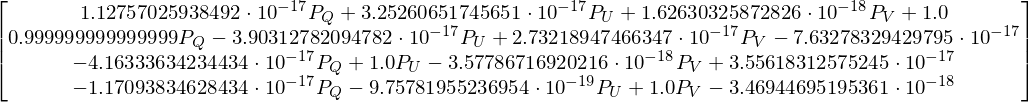

In [11]:
S = D*I
S

we see that $S$ is almost equal to $S_0$ except some numerical error.

In [12]:
Sper = D*Iper
# Sper # too long so we do not show this

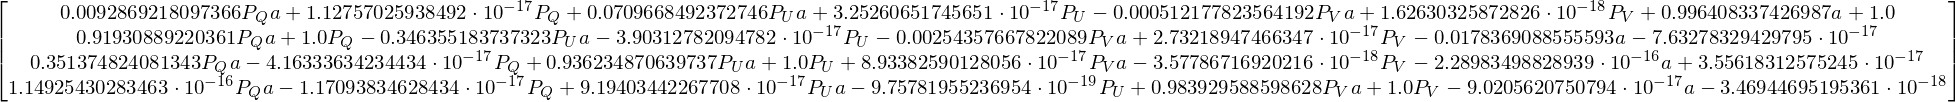

In [13]:
sym.simplify(Sper)

for the sake of simplicity, we remove values which are numerically small.

In [14]:
Sper_simple = sym.Matrix([
    [0.0092869218097366*PQ*a+0.0709668492372746*PU*a-0.000512177823564192*PV*a+0.996408337426987*a+1.0],
    [0.91930889220361*PQ*a+PQ-0.00254357667822089*PV*a-0.0178369088555593*a-0.346355183737323*PU*a],
    [0.936234870639737*PU*a+PU+0.351374824081343*PQ*a],
    [0.983929588598628*PV*a+PV]
])

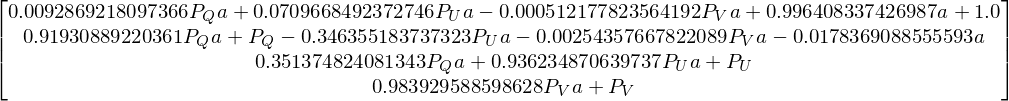

In [15]:
Sper_simple

as for the inversion error casued by persistence, for example,

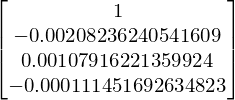

In [16]:
p = 0.2
temp = Sper_simple.evalf(subs={a:0.02, PQ:p, PU:p, PV:p})
temp/temp[0] - S0.evalf(subs={PQ:p, PU:p, PV:p}) + sym.Matrix([[1],[0],[0],[0]])

### plots to show the error vs (persistence ratio, degree of polarization)

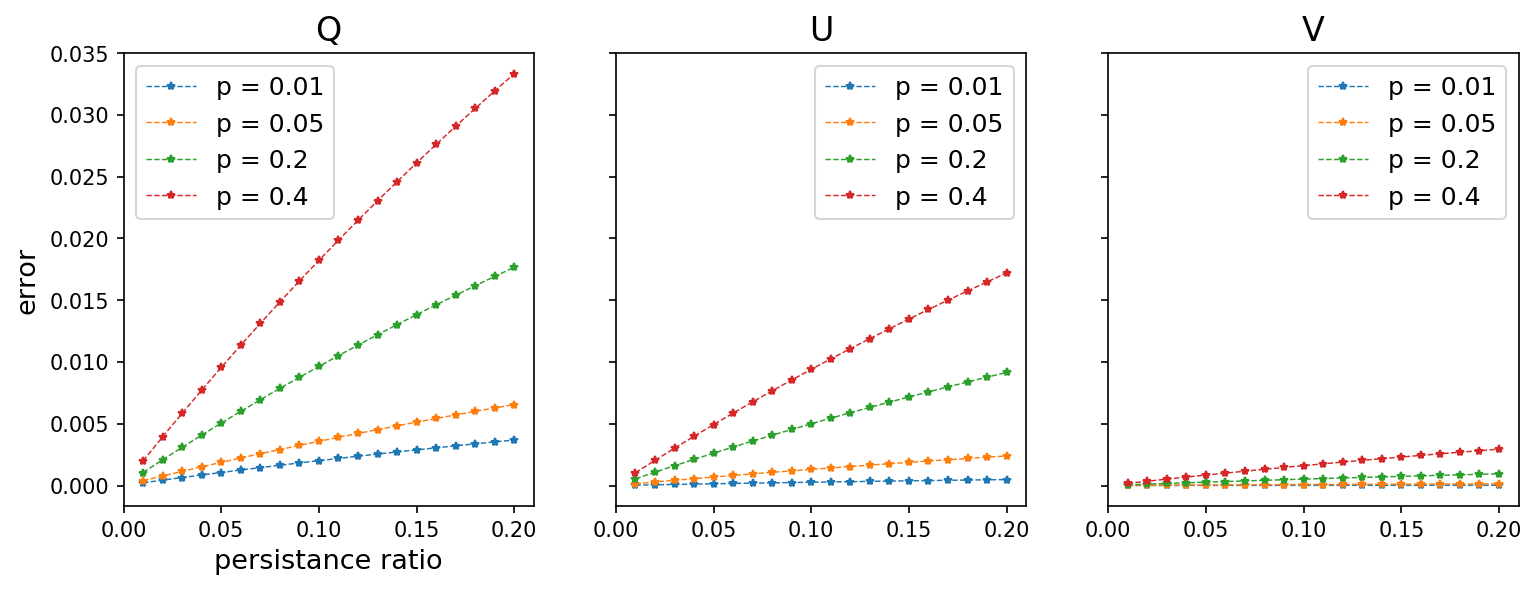

In [17]:
#
fig, ax = plt.subplots(1,3, figsize=(12,4), dpi=150, sharey=True)
aArray = np.linspace(0.01, 0.2, 20)
for p in [0.01, 0.05, 0.2, 0.4]:
    f = - S0.evalf(subs={PQ:p, PU:p, PV:p}) + sym.Matrix([[1],[0],[0],[0]])
    errorQ,errorU,errorV = [],[],[]
    for aa in aArray:
        temp = Sper_simple.evalf(subs={a:aa, PQ:p, PU:p, PV:p})
        temp1=temp/temp[0] + f
        errorQ.append(abs(float(temp1[1])))
        errorU.append(abs(float(temp1[2])))
        errorV.append(abs(float(temp1[3])))
    ax[0].plot(aArray, errorQ, '--*', markersize=4, label="p = {}".format(p),linewidth=0.7)
    ax[1].plot(aArray, errorU, '--*', markersize=4, label="p = {}".format(p),linewidth=0.7)
    ax[2].plot(aArray, errorV, '--*', markersize=4, label="p = {}".format(p),linewidth=0.7)
    ax[0].set_title("Q", fontsize=16)
    ax[1].set_title("U", fontsize=16)
    ax[2].set_title("V", fontsize=16)
    ax[0].set_xlabel("persistance ratio", fontsize=13)
    ax[0].set_ylabel("error", fontsize=13)
for i in range(3):
    ax[i].legend(loc='best', fontsize=12)
    ax[i].set_xlim(0, 0.21)